# Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
from tensorflow_addons.losses import pinball_loss
from tensorflow import function as tf_fun
from tensorflow import keras
from tensorflow.keras import Model
from math import log, sqrt, exp, erf, ceil, floor
from tqdm.notebook import tqdm, trange
import pandas as pd
from math import ceil

import scipy.stats as stats
from scipy.stats import qmc
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter
from scipy.stats import norm
from matplotlib import ticker

from importlib import reload

from numpy.random import seed   
from tensorflow.random import set_seed as tf_seed

tf_seed(1234) ; seed(1234)

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')

Init Plugin
Init Graph Optimizer
Init Kernel


/Users/alexanderithakis/miniforge3/envs/tf2/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Todo:
- Calculate sensitivities for changes to:
    - interest rate chages : 
        (1) IRS to stabilize this (but with 2% lower rate?)
        (2) stochastic interest rate process?
    - volatility changes   : 
        (1) Options to hedge against excessive volatility ?
        (2) stochastic volatility process
- V0 for different mu guesses:
    - its not dependent on it

Distribution of phi/psi over:
- mu
- r

Short cummings:
- r, mu, sigma correlations
    - if we dont by IRS. Volatility of r could be correlated with volatility of sigma if both are stochastic processes
- mu is very speculative.
- values where its not profitable to offer this product


# Simulate W1 & W2 Pahs

In [2]:
# Sobol - Quasi Monte Carlo for path simulation
def sobol_norm(m, d=1 ,seed=1234):
    sampler = qmc.Sobol(d, scramble=True, seed=seed)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)

In [3]:
""" Global Variables """
n_paths   = ceil(np.log2(3_000)) # for both Y and N
dt        = 1/(100) # Local: use greater than 42

rebalancing = 1/4 # Quarterly

## Y - Geometric Brownian Motion

Number of steps: 1001 
dt         = 0.010 year
----------------------------------------------------------------
Time to simulate: 0.647sec
mean Yt    = 2.615302
e^(mu * T) = 2.616925 
Diff       = -0.001623


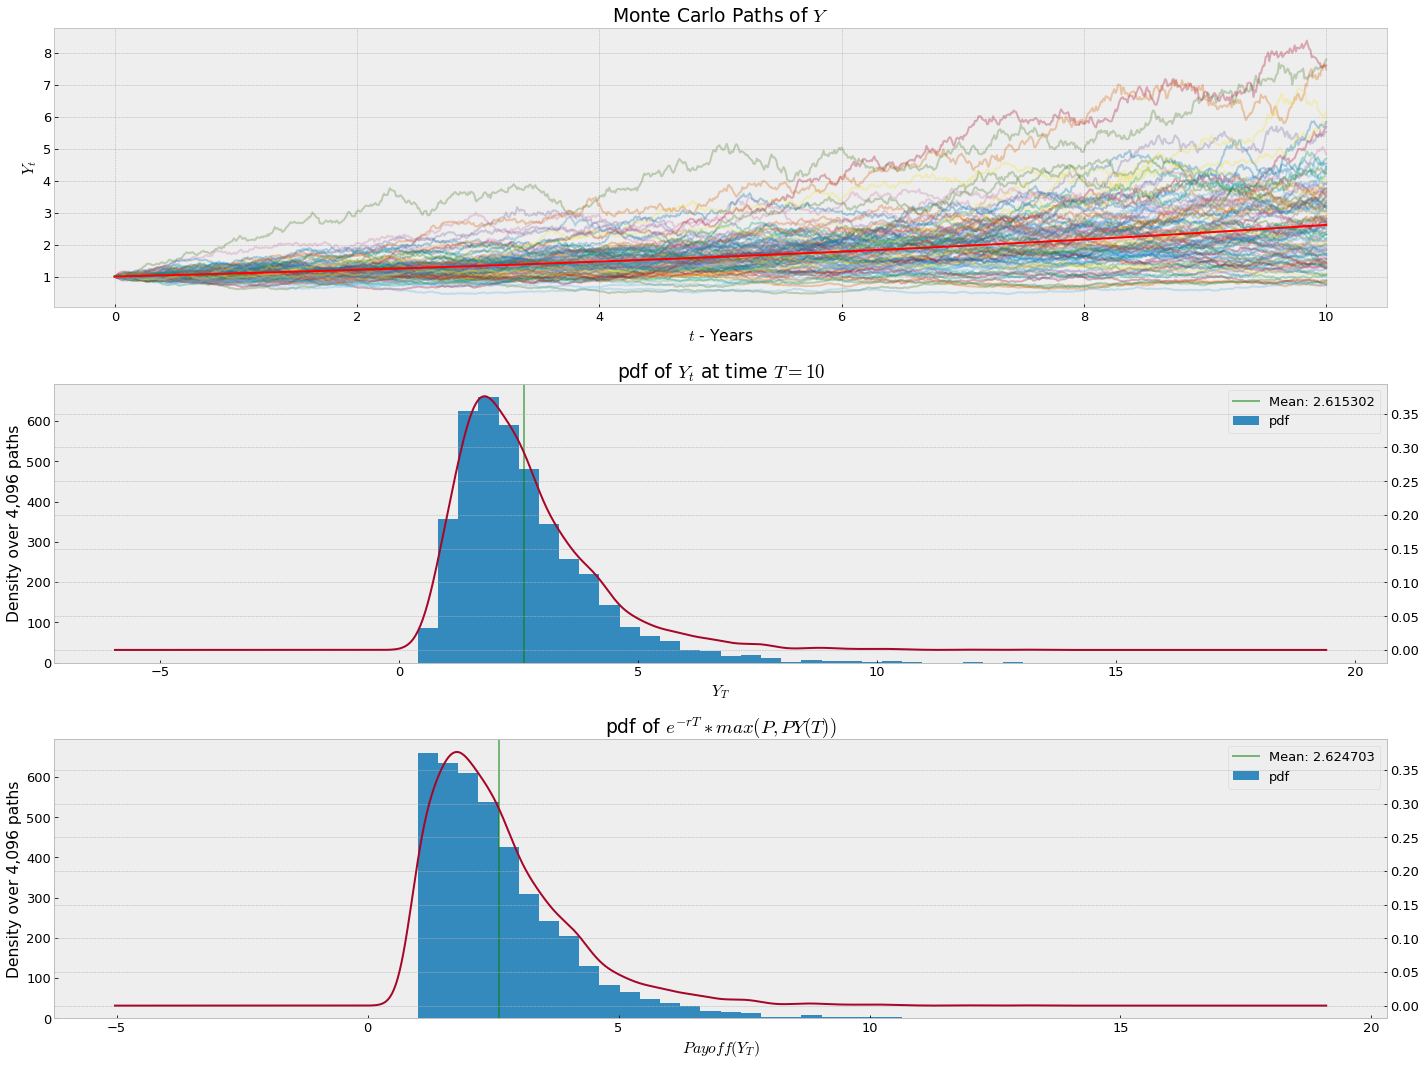

-------------------------------------
Expected Payoff = 2.624703
Discounted Expected Payoff = 1.944428
Prob Y < 1 = 5.40%


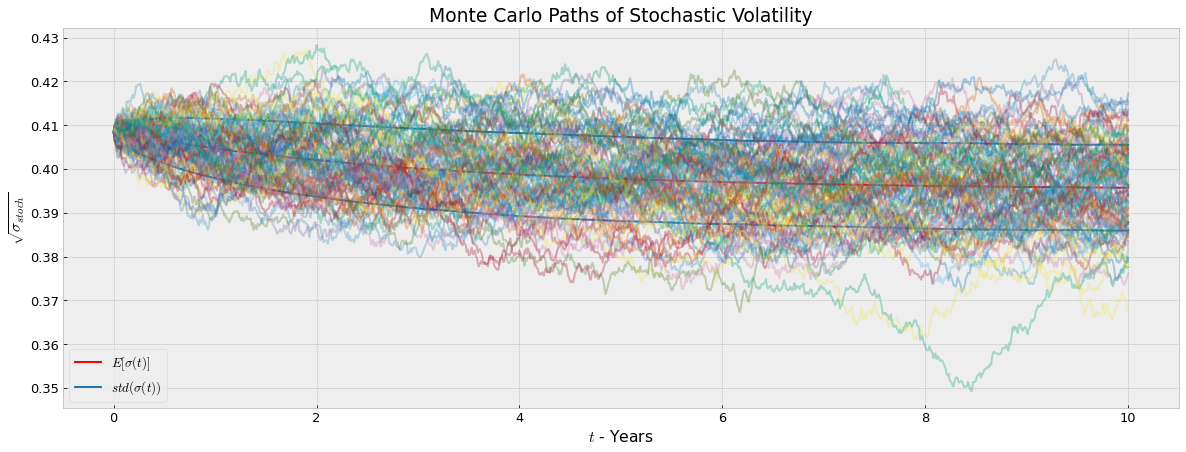

In [7]:
Y       = 1
T       = 10 # Years
mu      = 0.09620
r       = 0.03
s0      = 0.16679

n_time_steps = ceil(T/dt)+1 ; print(f'Number of steps: {n_time_steps} \ndt         = {dt:.3f} year')

SV = 1
""" SV parameters """
a        =0.0033281299103885727
b        =0.1562947229160206
c        =0.01583113545983743

timer=perf_counter()

""" Simulate Fund Price """
W1      = sobol_norm(n_paths, d=n_time_steps)
W_SV    = sobol_norm(n_paths, d=n_time_steps, seed=1235)
Y_paths = np.empty((2**n_paths, n_time_steps))
Y_paths[:,0] = np.log(Y)

""" SV - Verion """
vt = np.full(shape=(int(2**n_paths),n_time_steps), fill_value=s0) # initial variance 
print('----------------------------------------------------------------')
for t in range(1,n_time_steps):
    """ Advanced Version : continious time + Stochastic Volatility """
    # Simulate variance processes
    vt[:,t] = vt[:,t-1] + a*(b - vt[:,t-1]) + c*np.sqrt(vt[:,t-1]*dt)*W_SV[:,t]
    # Simulate log asset prices
    Y_paths[:,t] = Y_paths[:,t-1] + ((mu - 0.5*vt[:,t]**2)*dt + vt[:,t]*np.sqrt(dt)*W1[:,t])

Y_paths = np.exp(Y_paths)

""" Generate Bond Data """
B = np.exp(r*np.linspace(0,T, n_time_steps))
B = np.broadcast_to(B, Y_paths.shape)
print(f'Time to simulate: {perf_counter()-timer:.3f}sec')

fig, axs = plt.subplots(3, figsize=(20,15))
print(f'mean Yt    = {np.nanmean(Y_paths[:,-1]):.6f}')
print(f'e^(mu * T) = {np.exp(mu*T):.6f} \nDiff       = {np.nanmean(Y_paths[:,-1])-Y*np.exp(mu*T):.6f}')

rdf = pd.DataFrame(Y_paths.T, index=(np.linspace(0,T, n_time_steps)))
rdf.sample(100, axis=1).plot(legend=False, alpha=.3, ylabel=r'$Y_t$', xlabel=r'$t$ - Years', ax=axs[0], title=r'Monte Carlo Paths of $Y$') 
axs[0].plot(np.linspace(0,T, n_time_steps), np.exp(mu*np.linspace(0,T, n_time_steps)), c='r')

rdf.iloc[-1,:].hist(bins=30, ax=axs[1])
rdf.iloc[-1,:].plot(kind='kde', secondary_y=True, title=r'pdf of $Y_t$ at time $T=10$', ax=axs[1])
axs[1].axvline(np.nanmean(Y_paths[:,-1]), color='g', linestyle='-', alpha=.5)
axs[1].legend([f'Mean: {np.nanmean(Y_paths[:,-1]):.6f}', 'pdf'])
axs[1].set_xlabel(r'$Y_T$') ; axs[1].set_ylabel(f'Density over {Y_paths.shape[0]:,} paths')

Payoff_Y     = np.where(Y_paths[:,-1] > Y, Y_paths[:,-1], Y)
E_Payoff_Y   = Payoff_Y.mean()
payoff_df = pd.Series(Payoff_Y)
payoff_df.hist(bins=30, ax=axs[2])
payoff_df.plot(kind='kde', ind=10_000, secondary_y=True, title=r'pdf of $e^{-rT}*max(P, PY(T))$', xlabel=r'Y_t', ylabel='Density over 10,000 paths', ax=axs[2])
axs[2].axvline(E_Payoff_Y, color='g', linestyle='-', alpha=.5)
axs[2].legend([f'Mean: {E_Payoff_Y:.6f}', 'pdf'])
axs[2].set_xlabel(r'$Payoff(Y_T)$') ; axs[2].set_ylabel(f'Density over {Y_paths.shape[0]:,} paths')
plt.tight_layout() ; plt.show()

print('-------------------------------------')
# SE_Payoff_Y     = Payoff_Y.reshape(128, -1).mean(axis=0).std(ddof=1) / np.sqrt(128)
out_of_money_P  = np.where(Y_paths[:,-1] < Y, 1.0, 0.0).mean()
print(f'Expected Payoff = {E_Payoff_Y:.6f}')
print(f'Discounted Expected Payoff = {np.exp(-r*T)*E_Payoff_Y:.6f}')
print(f'Prob Y < 1 = {out_of_money_P*100:.2f}%')

if SV:
    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,T, n_time_steps), np.sqrt(vt).mean(axis=0), c='r')
    ax.plot(np.linspace(0,T, n_time_steps), np.sqrt(vt).std(axis=0) + np.sqrt(vt).mean(axis=0), c='tab:blue')
    ax.plot(np.linspace(0,T, n_time_steps), -np.sqrt(vt).std(axis=0) + np.sqrt(vt).mean(axis=0), c='tab:blue')
    ax.legend([r'$E[\sigma(t)]$', '$std(\sigma(t))$'])
    pd.DataFrame(np.sqrt(vt).T, index=(np.linspace(0,T, n_time_steps)))\
        .sample(100, axis=1).plot(legend=False, alpha=.3, ylabel=r'$\sqrt{\sigma_{stoch}}$', \
            xlabel=r'$t$ - Years', title='Monte Carlo Paths of Stochastic Volatility', ax=ax) 

# N(T) - Simulation

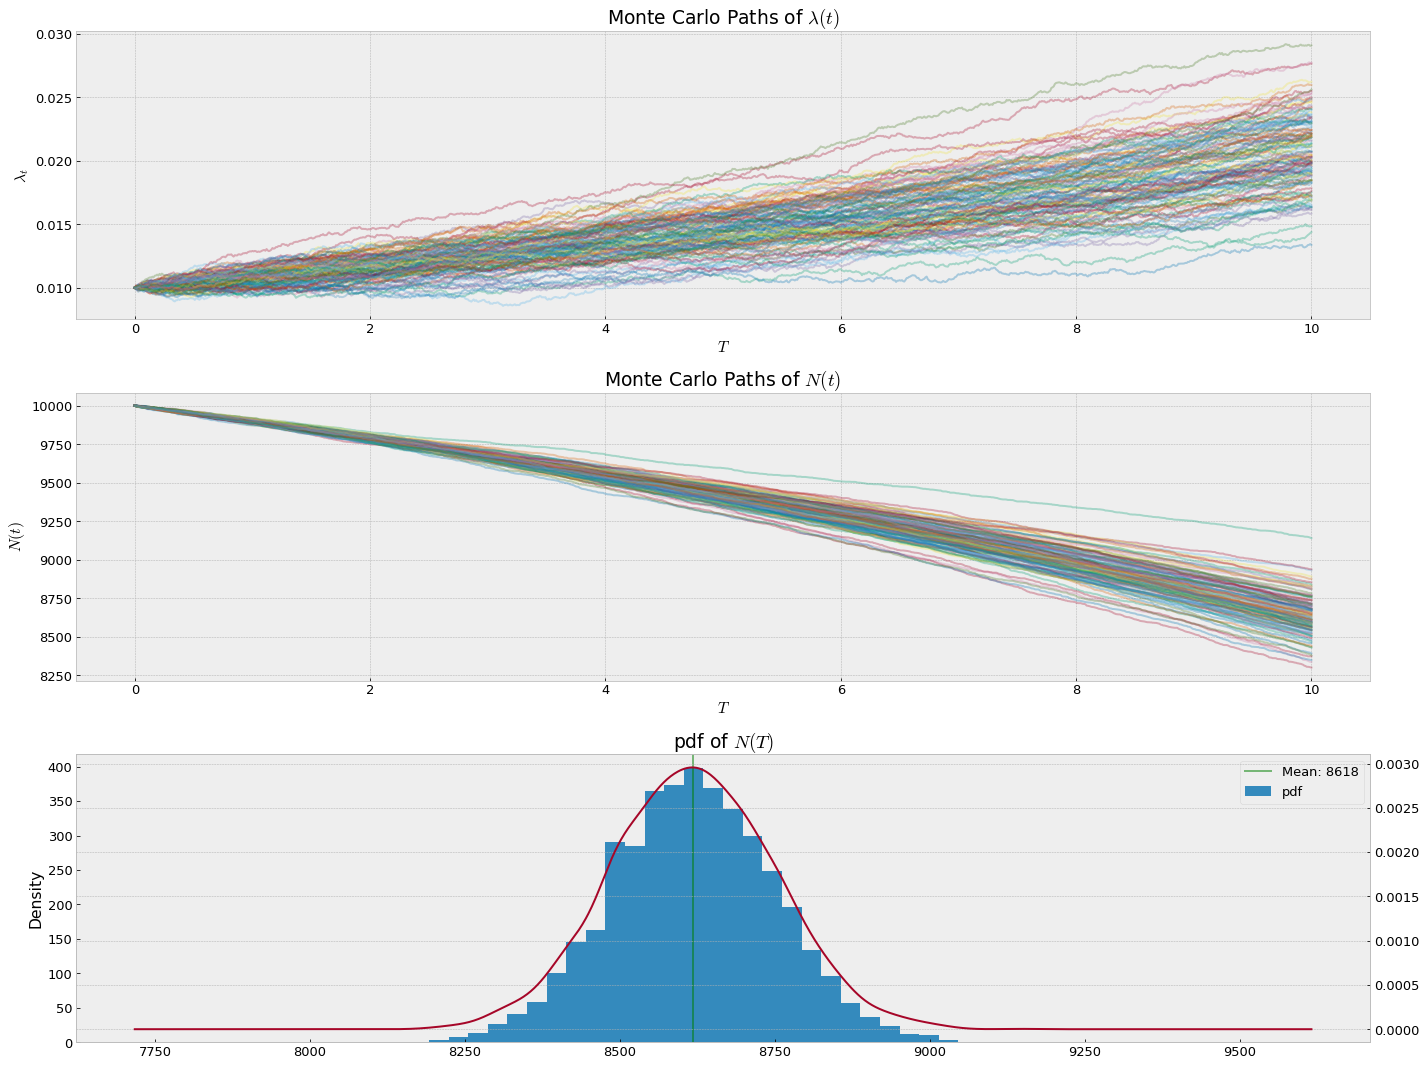

count   4,096
mean    8,618
std       132
min     8,192
50%     8,617
90%     8,786
95%     8,834
99%     8,933
max     9,141
--------------------------
Q99 N_T     = 8617.7 
Q99 SE      = 5.08
Q99_CI_95   = (8608, 8628)


In [45]:
N   = 10_000
x   = 55.0 # yo
l0  = 0.01
c   = 0.075
ita = 0.000597

""" Simulate Fund Price """
W2      = sobol_norm(n_paths, d=n_time_steps)
L_paths = np.empty((2**n_paths, n_time_steps))
L_paths[:,0] = l0
for t in range(1,n_time_steps):
    L_paths[:,t] = L_paths[:,t-1] + (c * L_paths[:,t-1] * dt + ita * np.sqrt(dt)*W2[:,t]).squeeze()

N_paths = np.empty((2**n_paths, n_time_steps), dtype=int)
N_paths[:,0] = N
""" Binomial Distribution of N(t) """
for t in range(1,n_time_steps):
    probabilities = np.exp(-L_paths[:,t]*dt)
    np.random.seed(1234+t) # to ensure reproducible results
    N_paths[:,t]  = np.random.binomial(N_paths[:,t-1], probabilities)

fig, axs = plt.subplots(3, figsize=(20,15))

rdf = pd.DataFrame(L_paths.T, index=(np.linspace(0,T, n_time_steps)))
rdf.sample(128, axis=1).plot(legend=False, alpha=.3, ylabel=r'$\lambda_t$', xlabel=r'$T$', ax=axs[0], title=r'Monte Carlo Paths of $\lambda(t)$') 

rdf = pd.DataFrame(N_paths.T, index=(np.linspace(0,T, n_time_steps)))
rdf.sample(128, axis=1).plot(legend=False, alpha=.3, ylabel=r'$N(t)$', xlabel=r'$T$', ax=axs[1], title=r'Monte Carlo Paths of $N(t)$') 

E_N_T    = N_paths[:,-1].mean()

N_T = pd.Series(N_paths[ N_paths[:,-1]>0 ,-1])
N_T.hist(bins=30, ax=axs[2])
N_T.plot(kind='kde', secondary_y=True, title=r'pdf of $N(T)$', xlabel=r'N_T', ylabel='Density over 10,000 paths', ax=axs[2])
axs[2].axvline(E_N_T, color='g', linestyle='-', alpha=.5)
axs[2].legend([f'Mean: {E_N_T:.0f}', 'pdf'])
plt.tight_layout() ; plt.show()

N_T_df = pd.Series(N_T)
str_form = lambda s: f'{s:,.0f}'
print(N_T_df.describe(percentiles=[.90, .95, .99]).to_string(float_format=str_form))
Q99_N_T     = np.quantile(N_paths[:,-1], 0.99)
Q99_N_T_SE  = np.quantile(N_paths[:,-1].reshape(128, -1), 0.99, axis=1).std(ddof=1) / np.sqrt(128)
# del N_paths ; del L_paths ; del N_T_df

print('--------------------------')
print(f'Q99 N_T     = {E_N_T:.1f} \nQ99 SE      = {Q99_N_T_SE:.2f}')
print(f'Q99_CI_95   = ({E_N_T - 1.96*Q99_N_T_SE:.0f}, {E_N_T + 1.96*Q99_N_T_SE:.0f})')

In [46]:
L_paths[:,-1].mean(), dt*c*1001

(0.021164326478894043, 0.75075)

In [47]:
reduction       = floor(n_time_steps/(T/rebalancing)) ;print(f'reduction = {reduction}')
Y_paths         = Y_paths[:, slice(0, None, reduction)]
B               = B[:, slice(0, None, reduction)]
n_time_steps  = ceil(n_time_steps/reduction) ; dt = dt *reduction

reduction = 25


# Expected Value of the Portfolio
The expected value of the portfolio should equal the discounted expected payoff of Y * the expected number of survivors. 


Q99_N_T, Q99_N_Tp   = 8,933 , 0.893 as percentage
E_Payoff_Y          = 2.241
EPY * Q99_N_Tp      = 2.002
D_E_Payoff_Y        = 1.660
D_EPY * Q99_N_Tp    = 1.483

Total possible outcomes simulated = 4,096
count   4,096.000
mean        2.002
std         0.981
min         0.893
50%         1.779
90%         3.244
95%         3.883
99%         5.361
max         9.455


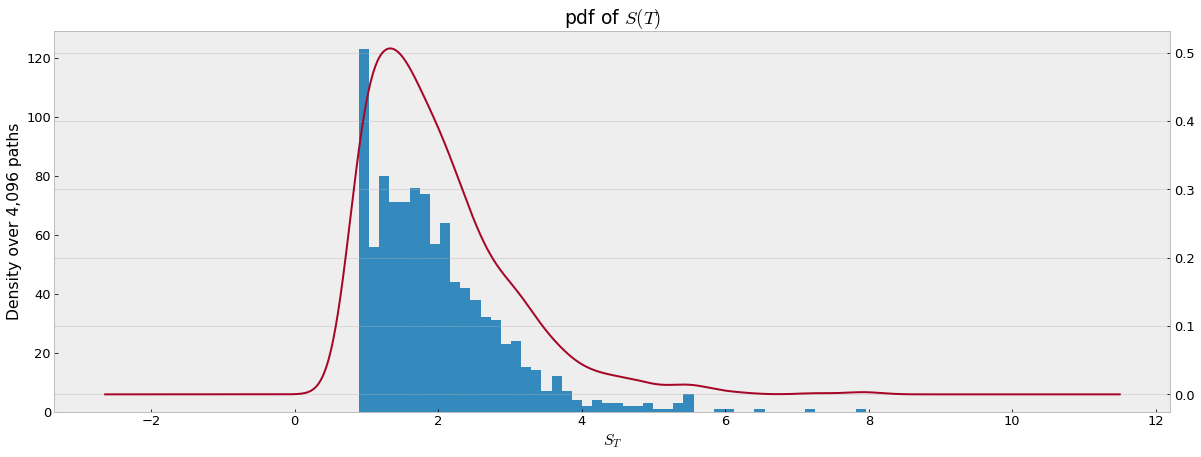

In [48]:
print(f"""
Q99_N_T, Q99_N_Tp   = {Q99_N_T:,.0f} , {Q99_N_T / N:,.3f} as percentage
E_Payoff_Y          = {E_Payoff_Y:,.3f}
EPY * Q99_N_Tp      = {E_Payoff_Y * Q99_N_T / N:,.3f}
D_E_Payoff_Y        = {E_Payoff_Y * np.exp(-r*T):,.3f}
D_EPY * Q99_N_Tp    = {E_Payoff_Y * np.exp(-r*T) * Q99_N_T / N:,.3f}
""")

Population_Survaval_rate_Q99 = Q99_N_T / N
S = Payoff_Y * Q99_N_T / N 
print(f'Total possible outcomes simulated = {S.shape[0]:,}')

S_df = pd.Series(S)
ax = S_df.sample(n=1_000).plot(kind='hist', bins=50, title=r'pdf of $S(T)$')
S_df.sample(n=1_000).plot(kind='kde', ind=10_000, secondary_y=True)
ax.set_xlabel(r'$S_T$')
ax.set_ylabel(f'Density over {S.shape[0]:,} paths')

str_form = lambda s: f'{s:,.3f}'
print(S_df.describe(percentiles=[.90, .95, .99]).to_string(float_format=str_form))
E_S   = S.mean()
D_E_S = E_S * np.exp(-r*T)


# Neural Network Hedging

In [49]:
def get_phi_psi(model, X0, mean=True):
    layer_output=model.get_layer('Phi_Psi').output
    pw_model = Model(inputs=[model.input], outputs=[layer_output])

    linear_layer_output = pw_model.predict(X0)
    if mean:
        return linear_layer_output[:,0].mean(), linear_layer_output[:,1].mean()
    else:
        return linear_layer_output[:,0], linear_layer_output[:,1]

        
def scheduler(epoch, lr):
    if epoch < 100 :
        return 1e-2
    elif epoch < 200 :
        return 1e-3
    elif epoch < 400 :
        return 5e-4
    else:
        return lr

rl_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [85]:
quantile = .5 + .45/n_time_steps
quantile = .99
@tf_fun
def quantile_loss(q, y, y_p):
        e = y-y_p
        return keras.backend.mean(keras.backend.maximum(q*e, (q-1)*e))

np.power(.0001, n_time_steps), quantile

(1.0000000000000019e-164, 0.99)

In [86]:
dense_initalizer = keras.initializers.RandomNormal(mean=0, stddev=0.1, seed=1234)
const_initalizer = keras.initializers.RandomNormal(mean=[1-out_of_money_P,out_of_money_P], stddev=0.0, seed=1234)

Input_S_N = keras.Input(shape=(2,), name='input: S_{t}, N_{t}') # LeakyReLU
x = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_1', kernel_initializer=dense_initalizer)(Input_S_N)
x = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_2', kernel_initializer=dense_initalizer)(x)
holdings = keras.layers.Dense(2, activation='linear', name='Phi_Psi', kernel_initializer=dense_initalizer, bias_initializer=const_initalizer)(x)

prices_1 = keras.Input(shape=(2,), name='input: S_{t}, B_{t}')
S_out    = keras.layers.Dot(axes = 1, name='V_t')([holdings, prices_1]) 

model = keras.Model(inputs=[Input_S_N, prices_1], outputs=S_out, name="Replicating_Portfolio")
# model.summary()
#------------------------#------------------------#------------------------#------------------------#------------------------#------------------------#------------------------
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3),
              loss = lambda y, y_p: quantile_loss(quantile, y, y_p), run_eagerly=False, 
              metrics=["mae", "mape"])

N_paths_NN = N_paths / N
values          = np.empty_like(Y_paths)
values[:,-1]    = Payoff_Y * N_paths_NN[:,-1] 

""" Calculate: Payoff for Options """
Flag = True ; its = 0
Errors      = np.zeros((1,2))
P_E_Values  = np.ones((1,3)) * S.mean()
Phi_Psi_HV  = []
for t_i in trange(n_time_steps-2, -1, -1):
    _Y_t  = Y_paths[:,t_i]
    _B_t  = B[:,t_i]
    _Y_t1 = Y_paths[:,t_i+1]
    _B_t1 = B[:,t_i+1]

    X0 = [np.stack((_Y_t, N_paths_NN[:,t_i]), axis=-1), np.stack((_Y_t, _B_t), axis=-1)]
    X1 = [np.stack((_Y_t, N_paths_NN[:,t_i]), axis=-1), np.stack((_Y_t1, _B_t1), axis=-1)]

    epochs = 300
    if Flag :
        # print(f'S.mean: {S.mean():.5f}\nP.mean: {model.predict(X0, verbose=0, batch_size=512).squeeze().mean():.5f}')
        callabacks = [rl_scheduler, keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)]
        Flag = False 
    else : 
        epochs = 20 
        callabacks = [callback]

    model.fit(X1, values[:,t_i+1], epochs=epochs, validation_split=0.0, verbose=0, batch_size=512, callbacks=callabacks) #, initial_epoch= 200 if t_i != n_time_steps-2 else 0)
    
    """ Get mean phi-psi """
    phi, psi = get_phi_psi(model, X0, mean=False)
    for f  in phi: Phi_Psi_HV.append([f,  t_i*dt, 'Phi'])
    for ps in psi: Phi_Psi_HV.append([ps, t_i*dt, 'Psi'])

    values[:,t_i] = model.predict(X0, verbose=0, batch_size=512).squeeze()

    Errors = np.append(Errors, np.array(model.evaluate(X1, values[:,t_i+1], batch_size=512)[1:]).reshape(1,2), axis=0) ; its += 1
    P_E_Values = np.append(P_E_Values, np.array([values[:,t_i].mean(), S.mean()*np.exp(-mu*dt*its), S.mean()*np.exp(-r*dt*its)]).reshape(1,3), axis=0)


  0%|          | 0/40 [00:00<?, ?it/s]

8/8 [==============================] - 0s 4ms/step - loss: 5.4532e-05 - mae: 0.0047 - mape: 0.2107


# Hedging Values

In [87]:
P = 100
N = 10_000
ADJUSTMENT_FACTOR = P * N

Phi t=0 : 9,732 Stocks
Psi t=0 : 210,661 Bonds


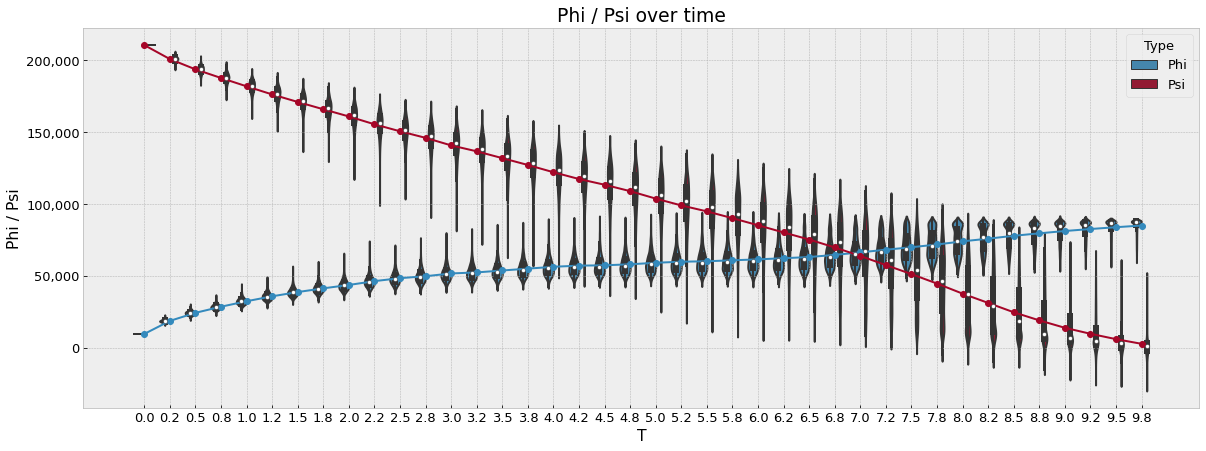

In [89]:
index = np.linspace(0, T, n_time_steps-1, endpoint = False)[::-1]
phi_psi_df = pd.DataFrame(Phi_Psi_HV, columns=['Value', 'T', 'Type'])
phi_psi_df.Value *= ADJUSTMENT_FACTOR * .1

ax = sns.violinplot(data=phi_psi_df, x="T", y="Value", hue="Type", dodge=1, cut=True)
ax.set_xticklabels([f'{x:,.1f}'for x in index][::-1])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

_ppg = phi_psi_df.groupby(['T', 'Type']).agg('mean')

title = 'Distribution of Phi/Psi over time'
phidf = _ppg.loc[_ppg.index.get_level_values('Type') == 'Phi'].groupby('T').mean().rename(columns={'Value':'Mean Phi'})['Mean Phi']
psidf = _ppg.loc[_ppg.index.get_level_values('Type') == 'Psi'].groupby('T').mean().rename(columns={'Value':'Mean Psi'})['Mean Psi']
phidf.index = range(0, phidf.shape[0]) ; psidf.index = range(0, psidf.shape[0])
phidf.plot(marker='o', ax=ax) ; psidf.plot(marker='o', ax=ax) ; 
ax.set_ylabel('Phi / Psi') ; ax.set_title('Phi / Psi over time')

print(f'Phi t=0 : {_ppg.loc[(0, "Phi")].mean():,.0f} Stocks')
print(f'Psi t=0 : {_ppg.loc[(0, "Psi")].mean():,.0f} Bonds')

# mu=8
# Phi t=0 : 777,032 Stocks
# Psi t=0 : 157,850 Bonds
# mu=5
# Phi t=0 : 741,979 Stocks
# Psi t=0 : 203,327 Bonds
# mu=3
# Phi t=0 : 724,146 Stocks
# Psi t=0 : 225,162 Bonds

# _ppg

ADJUSTED 
--------------------------------------------
Value at t_0 (Replicating-P)  = 220,392.418
Discounted Eq[S] ADJ          = 1,482,885.424
 Difference                   = -1,262,493.006 : -572.839% 
Discounted Ep[S] ADJ          = 899,415.474
 Difference                   = -679,023.056   : -308.097% 
Total Premium at t0           = 1,000,000 
Profit w/o TC                 = 779,608


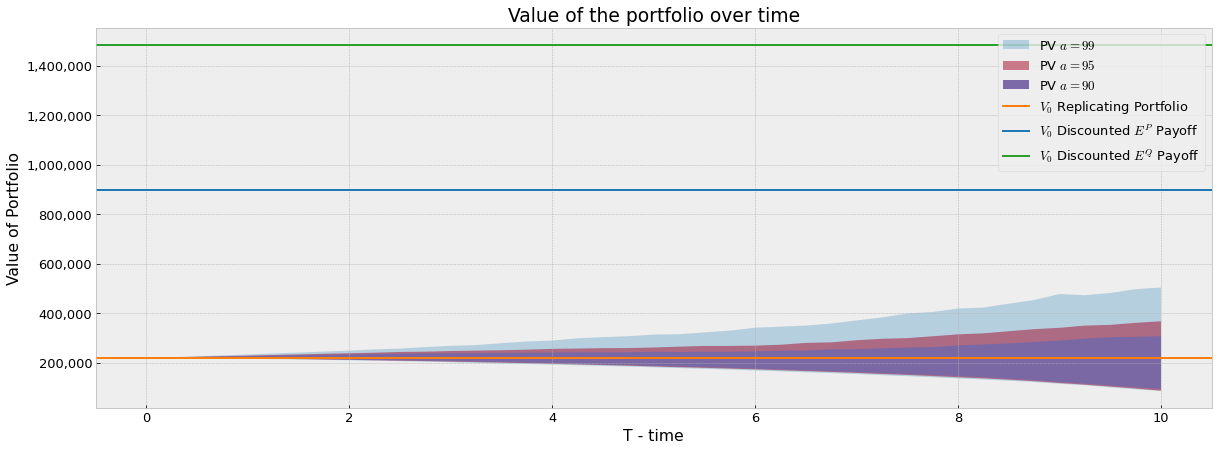

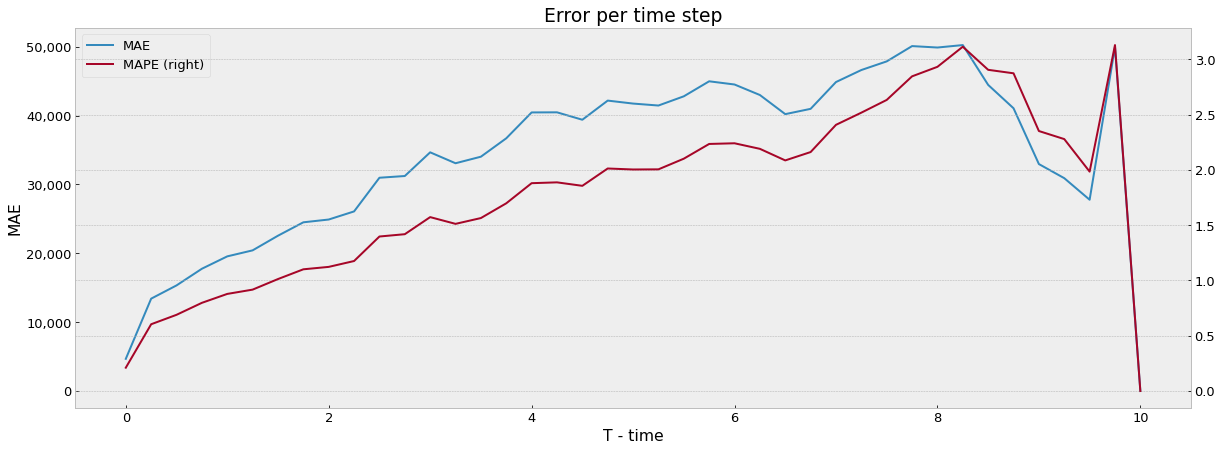

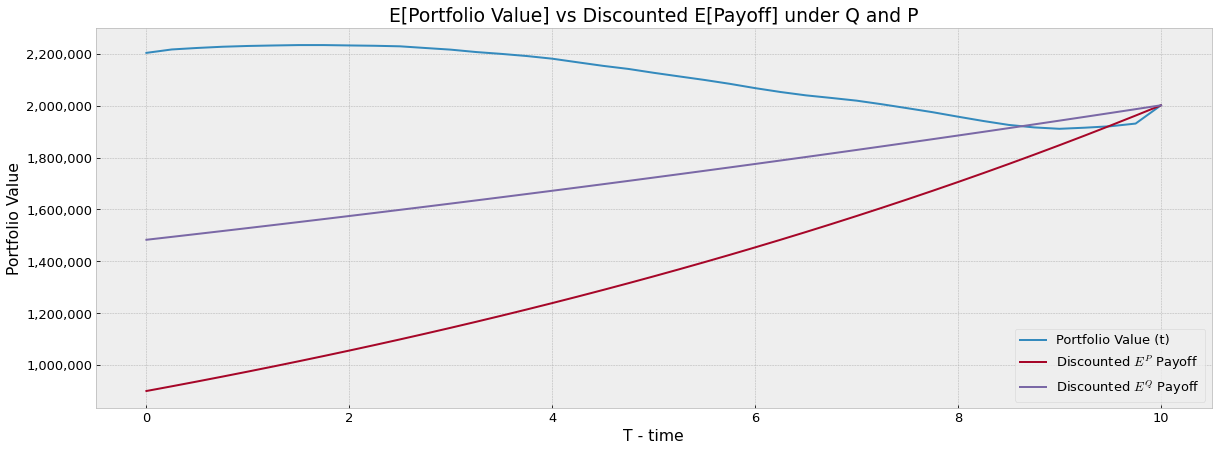

In [91]:
V0_RP = values[:,0].mean() * ADJUSTMENT_FACTOR *.1

qs = np.quantile(values, q=[.99, .95, .9, .1, .05, .01], axis=0) * ADJUSTMENT_FACTOR * .1
t  = np.linspace(0, T, n_time_steps)

fig, ax = plt.subplots()
ax.fill_between(t, qs[0,:].squeeze(), qs[-1,:].squeeze(), alpha=.3)
ax.fill_between(t, qs[1,:].squeeze(), qs[-2,:].squeeze(), alpha=.5)
ax.fill_between(t, qs[2,:].squeeze(), qs[-3,:].squeeze(), alpha=.99)
plt.ticklabel_format(style='plain', useLocale=True)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

ax.axhline(V0_RP, color='tab:orange')
ax.axhline(S.mean() * np.exp(-mu*T) * ADJUSTMENT_FACTOR, color='tab:blue')
ax.axhline(S.mean() * np.exp(-r*T) * ADJUSTMENT_FACTOR, color='tab:green')
ax.legend([r'PV $a=99$',r'PV $a=95$',r'PV $a=90$', r'$V_0$ Replicating Portfolio', r'$V_0$ Discounted $E^P$ Payoff', r'$V_0$ Discounted $E^Q$ Payoff'])
ax.set_xlabel('T - time') ; ax.set_ylabel('Value of Portfolio') ; ax.set_title('Value of the portfolio over time')

print('ADJUSTED \n--------------------------------------------')
print(f'Value at t_0 (Replicating-P)  = {V0_RP:,.3f}')
print(f'Discounted Eq[S] ADJ          = {S.mean() * np.exp(-r*T) * ADJUSTMENT_FACTOR:,.3f}')
print(f' Difference                   = {V0_RP - S.mean() * np.exp(-r*T) * ADJUSTMENT_FACTOR:,.3f} : {(V0_RP - S.mean() * np.exp(-r*T) * ADJUSTMENT_FACTOR)/V0_RP * 100:,.3f}% ')
print(f'Discounted Ep[S] ADJ          = {S.mean() * np.exp(-mu*T) * ADJUSTMENT_FACTOR:,.3f}')
print(f' Difference                   = {V0_RP - S.mean() * np.exp(-mu*T) * ADJUSTMENT_FACTOR:,.3f}   : {(V0_RP - S.mean() * np.exp(-mu*T) * ADJUSTMENT_FACTOR)/V0_RP * 100:,.3f}% ')
print(f'Total Premium at t0           = {ADJUSTMENT_FACTOR:,} \nProfit w/o TC                 = {ADJUSTMENT_FACTOR - V0_RP:,.0f}')

Errors_df = pd.DataFrame(np.array(Errors[::-1]), index=t, columns=['MAE', 'MAPE'])
Errors_df['MAE'] = Errors_df['MAE'] * ADJUSTMENT_FACTOR
ax = Errors_df.plot(legend=True, title='Error per time step', ylabel='MAE', secondary_y=['MAPE'])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}")) ; ax.set_xlabel('T - time')

E_Port_Values_df = pd.DataFrame(np.array(P_E_Values[::-1]), index=t, columns=['Portfolio Value (t)', r'Discounted $E^P$ Payoff', r'Discounted $E^Q$ Payoff']) * ADJUSTMENT_FACTOR
ax = E_Port_Values_df.plot(legend=True, title='E[Portfolio Value] vs Discounted E[Payoff] under Q and P', ylabel='Portfolio Value')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}")) ; ax.set_xlabel('T - time')

plt.show()

# Hedging Simulations

In [63]:
parameters = {
    'Y'       : 1,
    'K'       : 1,
    'T'       : 10, # Years
    'mu'      : 0.08,
    'r'       : 0.03,
    'sigma'   : 0.15,
    'dt'      : 1/(2),
    'SV' : False,        # Stochastic Volatility
    """ SV parameters """
    'theta' : sigma**2,    # Long run variance
    'kappa' : 0.01,        # mean reversion rate
    's_vol' : 0.1,         # volatility of variance
    'n_paths_Y'  : ceil(np.log2(3_000)),

    'reduction' : 1,

    'T'   : 10,
    'N'   : 10_000,
    'x'   : 55.0, # yo
    'l0'  : 0.01,
    'c'   : 0.075,
    'ita' : 0.000597,
    'dt'  : 1/(42),  # Monthly steps
    'n_paths_N' : ceil(np.log2(1_000))
}

In [50]:
import Replicating_Portfolio as RP
reload(RP)

IP = RP.Insurance_Portfolio(parameters, simulate=False)

rebalancing = 1/2 # quarterly

""" Step 1: Set up Y and N paths """
_y_reduction = floor(Y_paths.shape[1] / (T/rebalancing))
_n_reduction = floor(N_paths.shape[1] / (T/rebalancing))

Ypath = Y_paths[0,slice(0,None, _y_reduction)]
Npath = N_paths[0,slice(0,None, _n_reduction)]

""" Step 2: iterate over T """
tarray = np.linspace(0,T, Ypath.shape[0])
Results = {}
for idx in trange(Ypath.shape[0]):
    Yt = Ypath[idx]
    Nt = Npath[idx]
    
    # Calculate survival_rate
    parameters['N'] = Nt
    parameters['T'] = T - tarray[idx]
    print(survaval_parameters)
    N_t = RP.Simulate_N_T_outcomes(survaval_parameters)
    _Q99_N_T     = np.quantile(N_t, 0.99)

    # Calculate Replicating Portfolio Value and phi_psi values
    changed_parameters = {
    'Y': Yt,
    'T': T - tarray[idx],
    'survival_rate': _Q99_N_T/Nt,
    'ADJUSTMENT_FACTOR' : 100*Nt
    }
    print(changed_parameters)
    V0, PP = IP.Replicaitng_Portfolio_V0(changed_param=changed_parameters, make_plots=False, print_info=False, return_phi_psi=True)
    Results[tarray[idx]] = [Yt, Nt, V0, PP[0], PP[1]]
    

  0%|          | 0/21 [00:00<?, ?it/s]

{'T': 10.0, 'N': 10000, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


{'T': 9.5, 'N': 9939, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 19/19 [00:27<00:00,  1.42s/it]


{'T': 9.0, 'N': 9888, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 18/18 [00:26<00:00,  1.46s/it]


{'T': 8.5, 'N': 9841, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 17/17 [00:27<00:00,  1.61s/it]


{'T': 8.0, 'N': 9786, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 16/16 [00:24<00:00,  1.50s/it]


{'T': 7.5, 'N': 9731, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


{'T': 7.0, 'N': 9670, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


{'T': 6.5, 'N': 9613, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 13/13 [00:23<00:00,  1.84s/it]


{'T': 6.0, 'N': 9545, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


{'T': 5.5, 'N': 9482, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


{'T': 5.0, 'N': 9403, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


{'T': 4.5, 'N': 9347, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 9/9 [00:18<00:00,  2.08s/it]


{'T': 4.0, 'N': 9279, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 8/8 [00:19<00:00,  2.45s/it]


{'T': 3.5, 'N': 9199, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 7/7 [00:17<00:00,  2.43s/it]


{'T': 3.0, 'N': 9134, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 6/6 [00:15<00:00,  2.52s/it]


{'T': 2.5, 'N': 9051, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


{'T': 2.0, 'N': 8973, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 4/4 [00:13<00:00,  3.30s/it]


{'T': 1.5, 'N': 8879, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 3/3 [00:12<00:00,  4.06s/it]


{'T': 1.0, 'N': 8781, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 2/2 [00:11<00:00,  5.85s/it]


{'T': 0.5, 'N': 8709, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


100%|██████████| 1/1 [00:07<00:00,  7.10s/it]


{'T': 0.0, 'N': 8609, 'x': 55.0, 'l0': 0.01, 'c': 0.075, 'ita': 0.000597, 'dt': 0.023809523809523808, 'n_paths_N': 10}


0it [00:00, ?it/s]


In [51]:
Results_df = pd.DataFrame.from_dict(Results, orient='index')#, columns=['Yt', 'Nt', 'RP_Vt', 'Phi', 'Psi'])
Results_df.columns = ['Yt', 'Nt', 'RP_Vt', 'Phi', 'Psi']
Results_df.index.name = 't'
Results_df


,Yt,Nt,RP_Vt,Phi,Psi
t,,,,,
0.0,1.000000,10000,9.344933e+05,0.773144,0.161349
0.5,0.894844,9939,8.403456e+05,0.791483,0.132092
1.0,0.909405,9888,8.638117e+05,0.792046,0.143521
1.5,1.005148,9841,9.620678e+05,0.762952,0.195188
2.0,1.001123,9786,9.640492e+05,0.791640,0.171520
2.5,1.096884,9731,1.068288e+06,0.769499,0.224236
3.0,1.316253,9670,1.295843e+06,0.751563,0.306596
3.5,1.371754,9613,1.352717e+06,0.752812,0.320044
4.0,1.624419,9545,1.620206e+06,0.743184,0.412964


In [66]:
import Replicating_Portfolio as RP
reload(RP)

parameters = {
    'Y'       : 1,
    'K'       : 1,
    'T'       : 10, # Years
    'mu'      : 0.08,
    'r'       : 0.03,
    'sigma'   : 0.15,
    'dt'      : 1/(2),
    'SV' : False,        # Stochastic Volatility
    """ SV parameters """
    'theta' : sigma**2,    # Long run variance
    'kappa' : 0.01,        # mean reversion rate
    's_vol' : 0.1,         # volatility of variance
    'n_paths_Y'  : ceil(np.log2(3_000)),

    'reduction' : 1,

    'T'   : 10,
    'N'   : 10_000,
    'x'   : 55.0, # yo
    'l0'  : 0.01,
    'c'   : 0.075,
    'ita' : 0.000597,
    'dt_n'  : 1/(42),  # Monthly steps
    'n_paths_N' : ceil(np.log2(1_000))
}

res = RP.Calculate_V0_Phi_Psi(**parameters)

res

100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


(1048899.2929458618, 0.8563199, 0.19257939)

# Sensitivies

In [79]:
from importlib import reload
import Replicating_Portfolio
reload(Replicating_Portfolio)

parameters = {
    'Y'       : 1,
    'T'       : 10, # Years
    'mu'      : 0.08,
    'r'       : 0.03,
    'sigma'   : 0.15,
    'dt'      : 1/(100),
    'SV' : True,        # Stochastic Volatility
    """ SV parameters """
    'theta' : sigma**2,    # Long run variance
    'kappa' : 0.01,         # mean reversion rate
    's_vol' : 0.1,        # volatility of variance
    'n_paths_Y'  : ceil(np.log2(3_000)),

    'reduction' : 25,
    'survival_rate': Q99_N_T/N,
    'ADJUSTMENT_FACTOR':ADJUSTMENT_FACTOR,
    
}

IP = Replicating_Portfolio.Insurance_Portfolio(parameters, simulate=False)
""" IP options: 
Value           -  pamam_change : dict
sensitivity     -  param : dict
"""
# Over sigma
_sigmas = [.01, .05, .1, .15, .2, .25, .3]
_V0_s    = []
for _sigma in _sigmas:
    _V0 = IP.Replicaitng_Portfolio_V0(changed_param=('sigma', _sigma), make_plots=False, print_info=False)
    print(_sigma, _V0)
    _V0_s.append(_V0)

# Over r
_rhos   = [.00, .01, .02, .03, .04, .05, .06]
_V0s_r  = []
for _rho in _rhos:
    _V0 = IP.Replicaitng_Portfolio_V0(changed_param=('r', _rho), make_plots=False, print_info=False)
    print(_rho, _V0)
    _V0s_r.append(_V0)

# Over mu
_mus    = [.01, .02, .04, .06, .08, .12]
_V0s_mu = []
for _mu in _mus:
    _V0 = IP.Replicaitng_Portfolio_V0(changed_param=('mu', mu), make_plots=False, print_info=False)
    print(_mu, _V0)
    _V0s_mu.append(_V0)

_V0_s = pd.Series(_V0_s, index=_sigmas)
_V0_s.name = 'RP Value over simga' ; _V0_s.index.name = 'sigma'

_V0s_r = pd.Series(_V0s_r, index=_rhos)
_V0s_r.name = 'RP Value over Rho' ; _V0s_r.index.name = 'rho'

_V0s_mu = pd.Series(_V0s_mu, index=_mus)
_V0s_mu.name = 'RP Value over Rho' ; _V0s_mu.index.name = 'mu'

str_form = lambda s: f'{s:,.0f} EUR'
print(f'OVER SIGMA \n-------------------------')
print(_V0_s.to_string(float_format=str_form))
print(f'\n\nOVER RHO \n-------------------------')
print(_V0s_r.to_string(float_format=str_form))
print(f'\n\nOVER MU \n-------------------------')
print(_V0s_mu.to_string(float_format=str_form))

OVER SIGMA 
-------------------------
sigma
0.00             NaN
0.01             NaN
0.02     896,534 EUR
0.03     934,882 EUR
0.04     976,676 EUR
0.05   1,009,529 EUR
0.06   1,031,368 EUR


OVER RHO 
-------------------------
rho
0.00   1,017,191 EUR
0.01     982,426 EUR
0.02     952,596 EUR
0.03     934,882 EUR
0.04     922,329 EUR
0.05     912,798 EUR
0.06     906,062 EUR


OVER MU 
-------------------------
mu
0.01   934,882 EUR
0.02   934,882 EUR
0.04   934,882 EUR
0.06   934,882 EUR
0.08   934,882 EUR
0.12   934,882 EUR
